In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
import csv
import tensorflow as tf
import zipfile
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import Input, Model
from keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.applications import ResNet50

In [ ]:
!pip install kaggle
!mkdir .kaggle
!mv kaggle.json .kaggle
!mv .kaggle /root/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download -d trolukovich/food5k-image-dataset

In [ ]:
with zipfile.ZipFile('/content/food5k-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
TRAINING_PATH = '/content/training'
VALIDATION_PATH = '/content/validation'

In [ ]:
train_food_path = os.path.join(TRAINING_PATH, 'food')
train_nonfood_path = os.path.join(TRAINING_PATH, 'non_food')

validation_food_path = os.path.join(VALIDATION_PATH, 'food')
validation_nonfood_path = os.path.join(VALIDATION_PATH, 'non_food')

In [ ]:
index = 10

plt.figure(figsize=(10,10))
plt.subplot(221).set_title("Sample of Food (Training)")
plt.imshow(plt.imread(os.path.join(train_food_path, os.listdir(train_food_path)[index])))
plt.subplot(222).set_title("Sample of non-food (Training)")
plt.imshow(plt.imread(os.path.join(train_nonfood_path, os.listdir(train_food_path)[index])))
plt.subplot(223).set_title("Sample of Food (Testing)")
plt.imshow(plt.imread(os.path.join(validation_food_path, os.listdir(validation_food_path)[index])))
plt.subplot(224).set_title("Sample of non-food (Training)")
plt.imshow(plt.imread(os.path.join(validation_nonfood_path, os.listdir(validation_nonfood_path)[index])))

In [ ]:
training_food_size = len(os.listdir(os.path.join(TRAINING_PATH, 'food')))
training_nonfood_size = len(os.listdir(os.path.join(TRAINING_PATH, 'non_food')))
validation_food_size = len(os.listdir(os.path.join(VALIDATION_PATH, 'food')))
validation_nonfood_size = len(os.listdir(os.path.join(VALIDATION_PATH, 'non_food')))

print(f'There are {training_food_size} food samples and {training_nonfood_size} non-food samples in the training set')
print(f'There are {validation_food_size} food samples and {validation_nonfood_size} non-food samples in the validation set')

In [ ]:
target_shape = 150
training_batch = 128

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=TRAINING_PATH,
                                                    # batch_size=training_batch,
                                                    class_mode='binary',
                                                    target_size=(target_shape, target_shape))

validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_PATH,
                                                    class_mode='binary',
                                                    target_size=(target_shape, target_shape))

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
training_shape = plt.imread(os.path.join(train_food_path, os.listdir(train_food_path)[0])).shape
validation_shape = plt.imread(os.path.join(validation_food_path, os.listdir(validation_food_path)[0])).shape
print(f'The shape of training images is 3d {training_shape}')
print(f'The shape of validation images is also 3d {validation_shape}')

The shape of training images is 3d (341, 512, 3)
The shape of validation images is also 3d (298, 512, 3)


In [ ]:
labels = list(train_generator.class_indices)
labels

['food', 'non_food']

In [ ]:
train_generator.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

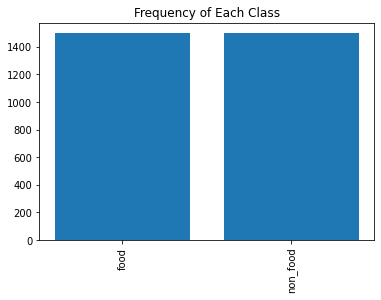

In [ ]:
values, counts = np.unique(train_generator.labels, return_counts=True)

plt.xticks(rotation=90)
plt.bar(x=labels, height=counts)
plt.title("Frequency of Each Class")
plt.show()

# CNN

In [ ]:
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(target_shape, target_shape, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

model.compile(optimizer=Adam(0.00001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 32)       0

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
94/94 [==============================] - 38s 378ms/step - loss: 0.6828 - acc: 0.6343 - val_loss: 0.6643 - val_acc: 0.7440
Epoch 2/20
94/94 [==============================] - 33s 352ms/step - loss: 0.6464 - acc: 0.7070 - val_loss: 0.6033 - val_acc: 0.7250
Epoch 3/20
94/94 [==============================] - 34s 361ms/step - loss: 0.5839 - acc: 0.7263 - val_loss: 0.5325 - val_acc: 0.7700
Epoch 4/20
94/94 [==============================] - 33s 352ms/step - loss: 0.5506 - acc: 0.7237 - val_loss: 0.5080 - val_acc: 0.7740
Epoch 5/20
94/94 [==============================] - 33s 351ms/step - loss: 0.5306 - acc: 0.7390 - val_loss: 0.4891 - val_acc: 0.7850
Epoch 6/20
94/94 [==============================] - 35s 371ms/step - loss: 0.5152 - acc: 0.7547 - val_loss: 0.4779 - val_acc: 0.7870
Epoch 7/20
94/94 [==============================] - 33s 350ms/step - loss: 0.5033 - acc: 0.7557 - val_loss: 0.4650 - val_acc: 0.7950
Epoch 8/20
94/94 [==============================] - 33s 350ms/step - 

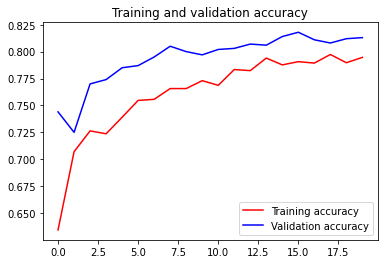

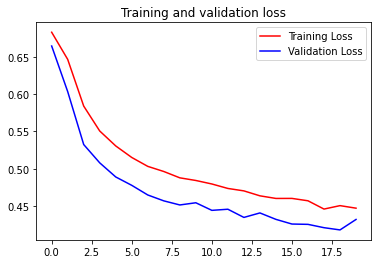

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see the model is overfitting after 10 epochs.

In [ ]:
model.evaluate_generator(validation_generator)

<ipython-input-41-8951cfd684a1>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(validation_generator)


[0.4718337059020996, 0.8299999833106995]

# ResNet

In [ ]:
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape=(target_shape,target_shape,3))

base_model.trainable = False
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation="sigmoid")(x)

resnet = Model(inputs=base_model.input, outputs=predictions)
resnet.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
resnet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
resnet_history = resnet.fit(train_generator, validation_data=validation_generator, epochs = 40)

Epoch 1/40
94/94 [==============================] - 39s 386ms/step - loss: 0.7014 - acc: 0.5260 - val_loss: 0.6807 - val_acc: 0.5150
Epoch 2/40
94/94 [==============================] - 37s 394ms/step - loss: 0.6882 - acc: 0.5553 - val_loss: 0.6743 - val_acc: 0.5090
Epoch 3/40
94/94 [==============================] - 35s 374ms/step - loss: 0.6835 - acc: 0.5557 - val_loss: 0.6551 - val_acc: 0.6760
Epoch 4/40
94/94 [==============================] - 35s 373ms/step - loss: 0.6775 - acc: 0.5660 - val_loss: 0.6503 - val_acc: 0.6610
Epoch 5/40
94/94 [==============================] - 35s 375ms/step - loss: 0.6677 - acc: 0.5913 - val_loss: 0.6315 - val_acc: 0.7140
Epoch 6/40
94/94 [==============================] - 35s 378ms/step - loss: 0.6682 - acc: 0.5857 - val_loss: 0.6189 - val_acc: 0.7370
Epoch 7/40
94/94 [==============================] - 35s 377ms/step - loss: 0.6531 - acc: 0.6260 - val_loss: 0.6140 - val_acc: 0.6630
Epoch 8/40
94/94 [==============================] - 37s 392ms/step - 

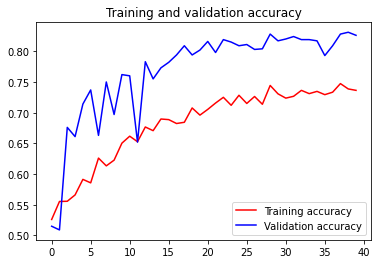

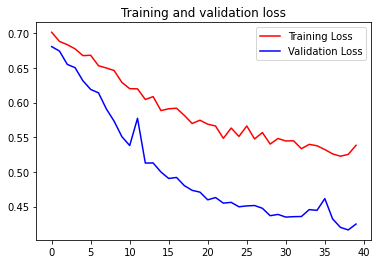

In [ ]:
acc = resnet_history.history['acc']
val_acc = resnet_history.history['val_acc']
loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()